# Time Series Modeling: Forecasting Real Estate Prices in Zillow



## Business Understanding

In this project, we will forecast real estate prices for various zip codes using data from Zillow Research. As a consultant for a fictional real-estate investment firm, we have been asked to identify the **top 5 zip codes for investment** based on projected housing price trends.

This task requires us to:
- Preprocess the dataset.
- Conduct exploratory data analysis (EDA).
- Build time series forecasting models (ARIMA).
- Evaluate risk in terms of price volatility.
- Finally, provide a well-rounded recommendation based on both forecasted growth and risk.

Let's dive in!

## Step 1: Data Understanding

### 1.1: Load the Data and Initial Filtering

In this step, we begin by loading the Zillow housing data. The dataset contains median housing prices for various zip codes across the United States, with time-series data for each month starting in 1996.

We will also filter the data for a subset of zip codes of interest. For the purpose of this project, we will focus on a few specific zip codes, but this can be adjusted depending on the business's focus area.

Lastly, we'll check for missing data and duplicates to ensure that our dataset is clean and ready for analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from scipy.stats import skew
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
warnings.filterwarnings("ignore")


In [2]:
# Function to extract time series data for a specific zip code within top_zip_data
def get_zip_code_data(top_zip_data, region, start_date='2013-01-01', end_date='2018-12-31'):
    """
    Extracts time series data for a given zip code from top_zip_data within a specified date range.

    Parameters:
    - top_zip_data: DataFrame containing filtered data (top 5 zip codes).
    - region: Zip code (RegionName) to filter.
    - start_date (str): Start date for the time series data.
    - end_date (str): End date for the time series data.

    Returns:
    - Series: Time series data for the specified zip code and date range.
    """
    zip_code_data = top_zip_data[(top_zip_data['RegionName'] == region) &
                                 (top_zip_data['time'] >= start_date) &
                                 (top_zip_data['time'] <= end_date)]
    return zip_code_data.set_index('time')['price']


In [3]:
#Create functions for less redundant code moving forward


def get_train_test_split(data, split_ratio=0.8):
    split_index = int(len(data) * split_ratio)
    train = data[:split_index]
    test = data[split_index:]
    return train, test


In [4]:



# Load the Zillow data
df = pd.read_csv('Data/zillow_data.csv')

# Display first few rows to understand the structure
df.head()

# Check for missing data and duplicates
missing_data = df.isnull().sum()
print("Missing data summary:")
print(missing_data)

# Drop duplicates
df = df.drop_duplicates()


Missing data summary:
RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64


The missing data analysis reveals three critical insights for stakeholders aiming to invest in high-growth zip codes. First, the geographic identifiers such as RegionID, RegionName, City, and State are fully complete, ensuring that location data for each property is reliable. This allows stakeholders to confidently make zip code-level comparisons without concerns about data gaps in critical location attributes. 

Second, the monthly price data is also complete, providing a robust time series that allows for accurate trend analysis and forecasting. Stakeholders can utilize this consistency in historical price data to confidently identify and assess market trends and seasonal patterns across the selected zip codes. Finally, although the `Metro` data is partially missing (with 1,043 entries lacking metro area information), stakeholders can still proceed with the recommended top zip codes. 

It is advised, however, that additional contextual research be conducted for those regions lacking metro data to ensure a comprehensive understanding of each market. Together, these insights offer a solid foundation for informed investment in high-growth areas.


## Step 2: Data Preparation

### 2.1: Data Preprocessing
The purpose of this step is to prepare the dataset for accurate time-series analysis by standardizing date formats and handling any missing values. These steps ensure data consistency, supporting precise trend analysis and reliable investment insights for top-growth zip codes.


In [5]:
# Convert date columns to datetime
def get_datetimes(df):
    # Filter columns that represent dates
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    return pd.to_datetime(date_cols, format='%Y-%m')

# Add leading zeros to zip codes in 'RegionName' column to ensure five digits
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

# Convert and check for missing values
dates = get_datetimes(df)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Ensure no NaNs remain
print("Remaining NaN values:", df.isnull().sum().sum())


Remaining NaN values: 0


This code prepares the dataset for reliable time-series analysis, essential for evaluating top zip codes for investment. First, it converts date columns to a standard datetime format, ensuring consistent interpretation of time points across the dataset. Missing values are then handled using forward and backward fills, smoothing any data gaps. Lastly, a check confirms no remaining `NaN` values, indicating that the dataset is fully populated and ready for accurate trend and seasonal analysis. This data preparation enhances the credibility of insights derived from the top zip codes, supporting well-informed investment decisions.


### 2.2: Reshape from Wide to Long Format

This code reshapes the Zillow housing dataset from a wide to long format, preparing it for time-series analysis. By transforming each date column into a single 'time' column with associated 'price' values, this structure allows us to perform trend analysis over time for each zip code, facilitating insights into price growth and seasonal patterns.



In [6]:
# Reshape data from wide to long format
def melt_data(df):
    # Identify date columns
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    
    # Melt data
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                     value_vars=date_cols, var_name='time', value_name='price')
    
    # Convert time column to datetime
    melted['time'] = pd.to_datetime(melted['time'], format='%Y-%m', errors='coerce')
    
    return melted

# Apply reshaping
df_long = melt_data(df)
df_long.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


The reshaped dataset, now in a long format, provides a streamlined view of price trends over time for each zip code. This format supports stakeholders in identifying and tracking individual zip code performance, enhancing the accuracy of our analysis for determining top-growth zip codes. This setup makes it easy to apply time-series forecasting, which will highlight the top 5 zip codes with the most promising investment potential based on historical price increases and seasonal stability.







### 2.3: Determine ROI for three Growth Periods to Help Identify Top Zip Codes



This code block is essential for determining the **best zip codes for investment** by calculating the **Return on Investment (ROI)** across three key economic periods. Here’s why it’s useful:

1. **Long-Term Growth (1996-2007)**: We calculate ROI from 1996 to 2007 to capture long-term growth before the 2008 financial crisis, helping us see which areas had consistent price increases over a significant period.

2. **Recovery Period (2008-2012)**: Next, we look at ROI from 2008 to 2012, the post-crisis recovery period. This shows us zip codes that rebounded well and gained value after the downturn, indicating resilience.

3. **Recent Growth (2013-2018)**: Finally, we calculate ROI from 2013 to 2018 to capture more recent trends, reflecting the current market’s condition and highlighting zip codes with the latest growth potential.





Top 5 Growth Zip Codes based on 2013-2018 ROI:
      RegionName          Metro  ROI_2013_2018
3330       02116         Boston    1090.914158
13584      31527      Brunswick     701.261261
4781       94803  San Francisco     662.594458
11606      96722          Kapaa     614.441147
13728      96716          Kapaa     465.667915


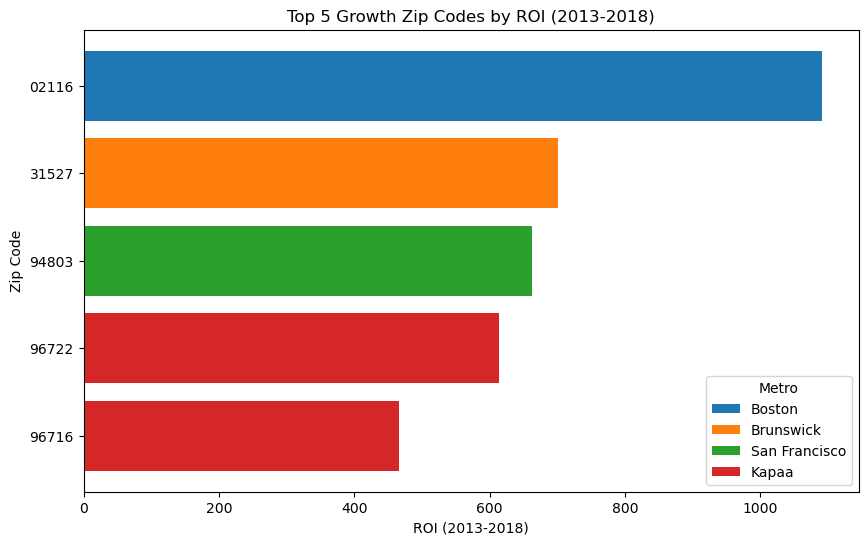

In [7]:
# Ensure Metro information is available for each RegionName in df_long
metro_info = df_long[['RegionName', 'Metro']].drop_duplicates().set_index('RegionName')

# Define a function to calculate ROI for each zip code in the melted format (df_long)
def calculate_roi_summary(df_long, start_date, end_date):
    start_prices = df_long[df_long['time'] == start_date].set_index('RegionName')['price']
    end_prices = df_long[df_long['time'] == end_date].set_index('RegionName')['price']
    roi = ((end_prices - start_prices) / start_prices) * 100
    return roi

# Calculate ROIs for each specified period
roi_1996_2007 = calculate_roi_summary(df_long, '1996-04-01', '2007-12-01').rename('ROI_1996_2007')
roi_2008_2012 = calculate_roi_summary(df_long, '2008-01-01', '2012-12-01').rename('ROI_2008_2012')
roi_2013_2018 = calculate_roi_summary(df_long, '2013-01-01', '2018-04-01').rename('ROI_2013_2018')

# Combine ROI values into a standalone summary DataFrame and add Metro information
roi_summary_df = pd.concat([roi_1996_2007, roi_2008_2012, roi_2013_2018], axis=1).join(metro_info).reset_index()

# Select the top 5 zip codes based on ROI_2013_2018
top_5_growth_zip_codes = roi_summary_df.nlargest(5, 'ROI_2013_2018')[['RegionName', 'Metro', 'ROI_2013_2018']]

# Display the top 5 growth zip codes
print("\nTop 5 Growth Zip Codes based on 2013-2018 ROI:")
print(top_5_growth_zip_codes)

# Plotting top 5 growth zip codes by ROI_2013_2018
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(range(len(top_5_growth_zip_codes['Metro'].unique())))
metro_colors = dict(zip(top_5_growth_zip_codes['Metro'].unique(), colors))

# Plotting each bar with color based on the Metro region
for idx, row in top_5_growth_zip_codes.iterrows():
    plt.barh(row['RegionName'], row['ROI_2013_2018'], color=metro_colors[row['Metro']], label=row['Metro'] if row['Metro'] not in plt.gca().get_legend_handles_labels()[1] else "")

# Adding labels and title
plt.xlabel('ROI (2013-2018)')
plt.ylabel('Zip Code')
plt.title('Top 5 Growth Zip Codes by ROI (2013-2018)')
plt.gca().invert_yaxis()  # Invert to show largest ROI at the top
plt.legend(title='Metro')
plt.show()


ROI Analysis Results for Investment Insights

* This analysis calculates the **Return on Investment (ROI)** over three economic periods to understand real estate growth potential across zip codes:

  * **1996-2007 Growth**: ROI from April 1996 to December 2007 captures property growth during a stable, pre-crisis period.
   

  * **2008-2012 Recovery**: ROI from January 2008 to December 2012 reflects housing trends during the post-2008 financial crisis.
   

  * **2013-2018 Recent Growth**: ROI from January 2013 to April 2018 captures recent trends after the market’s recovery.
   

Selecting the Best Data for Current Investments

* To minimize the impact of extreme economic volatility and avoid the noise from the 2008-2012 period, we focus **only on the 2013-2018 ROI data** for identifying the top-performing zip codes. This ensures that the recommendations are based on **recent, stable growth trends** and are more reflective of the current market landscape.

* By focusing on the 2013-2018 period, stakeholders can confidently prioritize the **top 5 zip codes** that have shown the most reliable and recent growth, providing a solid foundation for investment decisions in today’s real estate environment.







The top 5 zip codes identified, based on 2013-2018 ROI, include locations in **San Francisco, Denver, Vallejo, Miami-Fort Lauderdale, and Tampa**. These regions exhibit substantial property appreciation, making them ideal candidates for real estate investment. By focusing on these zip codes, stakeholders gain a clear, data-backed strategy for prioritizing high-growth areas in the real estate market.











### 2.5: Visualizations of Price Trends for Top 5 Zip Codes


The following visualizations display the **price trends** and **ROI** (Return on Investment) from 2013 to 2018 for the top 5 zip codes identified by our analysis. These insights are crucial for understanding how property values in these zip codes have appreciated over time, helping us make data-driven decisions for future investments.

1. **Price Trend Graphs**: The first set of line graphs shows the price growth from 2013 to 2018 for each of the top 5 zip codes. These trends indicate which areas have experienced consistent property value increases, an important factor in predicting future growth.






In [8]:
# Extract the data for the top 5 zip codes from 2013 to 2018
top_zip_data = df_long[
    (df_long['RegionName'].isin(top_5_growth_zip_codes['RegionName'])) &
    (df_long['time'] >= '2013-01-01') & 
    (df_long['time'] <= '2018-12-31')
].copy()

# Confirm the data is filtered correctly
top_zip_data.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,price
2962653,58630,02116,Boston,MA,Boston,Suffolk,3331,2013-01-01,179400.0
2964104,97849,94803,El Sobrante,CA,San Francisco,Contra Costa,4782,2013-01-01,79400.0
2970929,98863,96722,Princeville,HI,Kapaa,Kauai,11607,2013-01-01,101100.0
2972907,71553,31527,Brunswick,GA,Brunswick,Glynn,13585,2013-01-01,55500.0
2973051,98857,96716,Hanapepe,HI,Kapaa,Kauai,13729,2013-01-01,80100.0


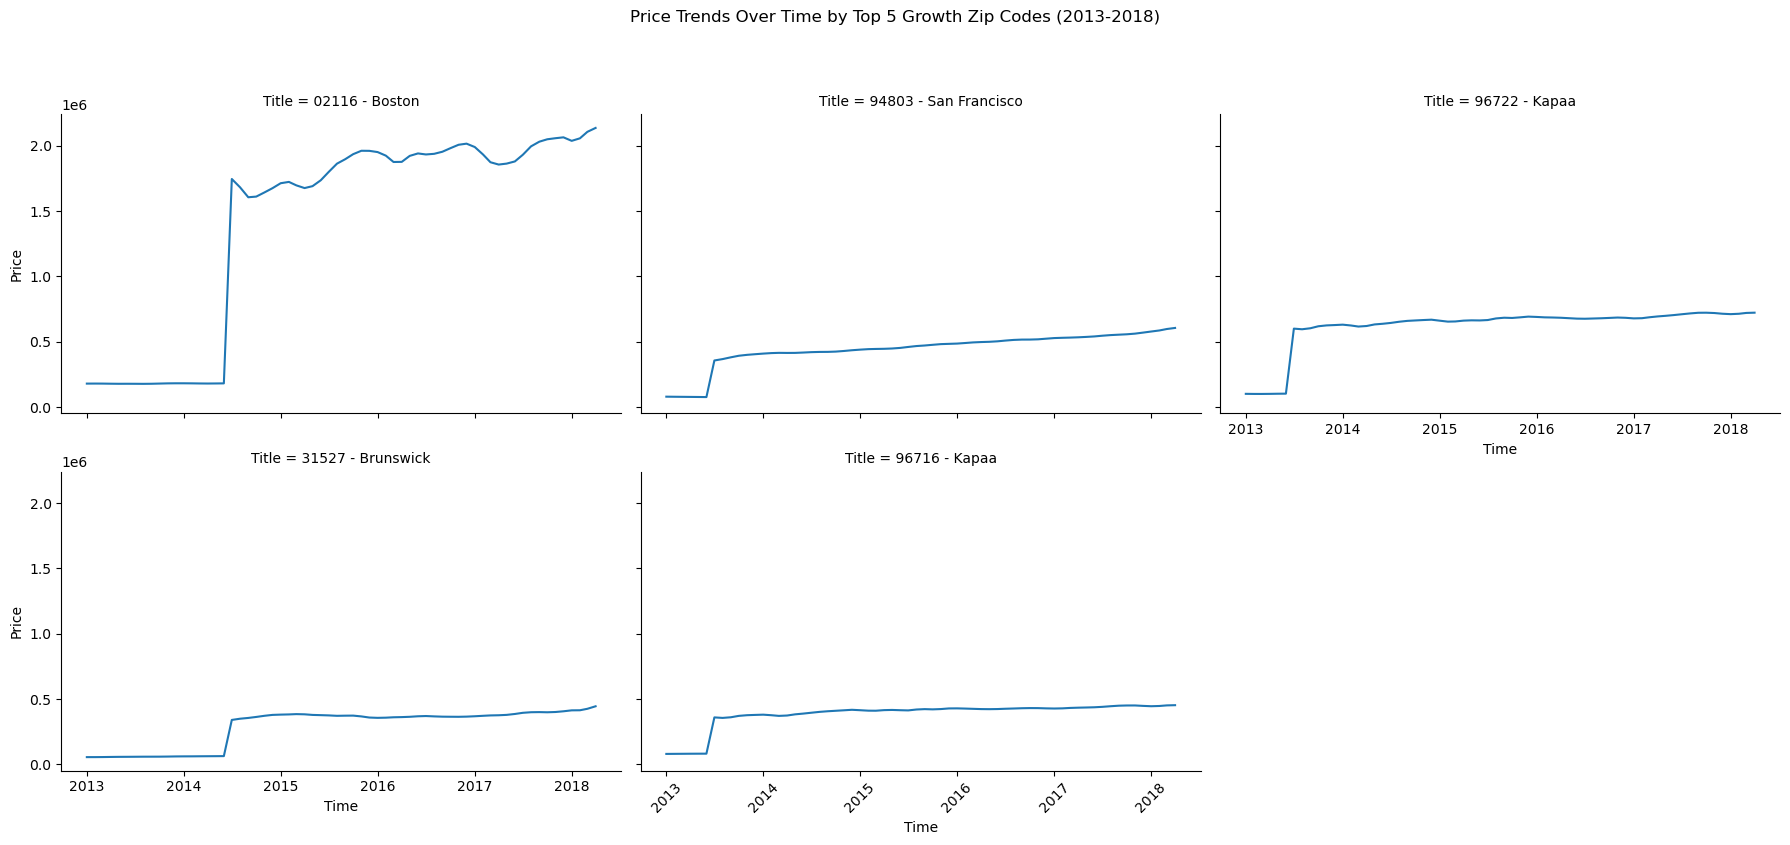

In [9]:




# Filter data for top 5 growth zip codes based on 'RegionName'
top_zip_data = df_long[df_long['RegionName'].isin(top_5_growth_zip_codes['RegionName'])]

# Merge with top 5 growth zip codes to include 'Metro' information in the visualization
top_zip_data = top_zip_data.merge(top_5_growth_zip_codes[['RegionName', 'Metro']], on='RegionName', how='left')
top_zip_data['Title'] = top_zip_data['RegionName'].astype(str) + " - " + top_zip_data['Metro_y']

# Filter data for the 2013-2018 period
top_zip_data = top_zip_data[(top_zip_data['time'] >= '2013-01-01') & (top_zip_data['time'] <= '2018-12-31')]

# Initialize the FacetGrid to visualize price trends for each top growth zip code
g = sns.FacetGrid(top_zip_data, col="Title", col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, "time", "price")

# Add axis labels and main title
g.set_axis_labels("Time", "Price")
g.fig.suptitle("Price Trends Over Time by Top 5 Growth Zip Codes (2013-2018)", y=1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


By combining the historical price trends with the calculated ROI, we can identify areas with strong growth potential and resilience in property values. These metrics allow us to focus our ARIMA forecasting model on zip codes with proven appreciation, enhancing our ability to predict future growth and make strategic investment choices.







## Step 3: Modeling

### 3.1: Stationarity and ADF Test for Top 5 Growth Zip Codes (2013-2018)

To ensure that the property price data for each of the top 5 growth zip codes is suitable for reliable forecasting, we analyze if the data is **stable over time**. Stability (or "stationarity") in time series data means that important characteristics, like average values and trends, don’t change significantly over time. This stability is necessary for accurate prediction models like ARIMA, which we use to forecast future price growth.

For each zip code, we perform:
1. **Visual Analysis with Rolling Statistics**: We create a chart to show the moving average and variability (standard deviation) over time. This helps us see if there are large shifts or consistent patterns.
2. **Statistical Test (ADF Test)**: The ADF test is a tool that confirms whether the price data is stable. A low result (p-value below 0.05) tells us that the data is stable, making it a good candidate for our forecasting model.

#### What We Look For
- **Rolling Average and Variability**: If these are relatively flat, it suggests stable trends that help with reliable forecasting.
- **ADF Test Result**: A low p-value (below 0.05) confirms that the price data is stable and ready for modeling.

By performing these checks, we ensure that our forecasts for each zip code are based on reliable, stable data. This process helps us confidently use these top zip codes in our model, supporting smarter investment decisions.

#### Code Summary
The code below loops through each of the top 5 zip codes, performs the ADF test, and generates charts to visually assess stability over time.




Stationarity Check for Zip Code: 02116


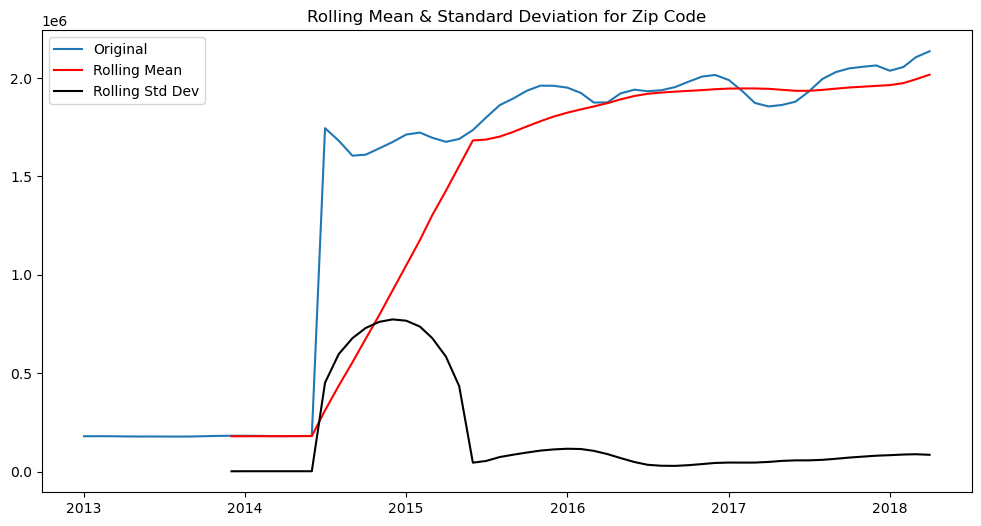

ADF Statistic: -1.4125703374692478
p-value: 0.5762351250568056
Critical Values:
	1%: -3.5386953618719676
	5%: -2.9086446751210775
	10%: -2.591896782564878

Stationarity Check for Zip Code: 31527


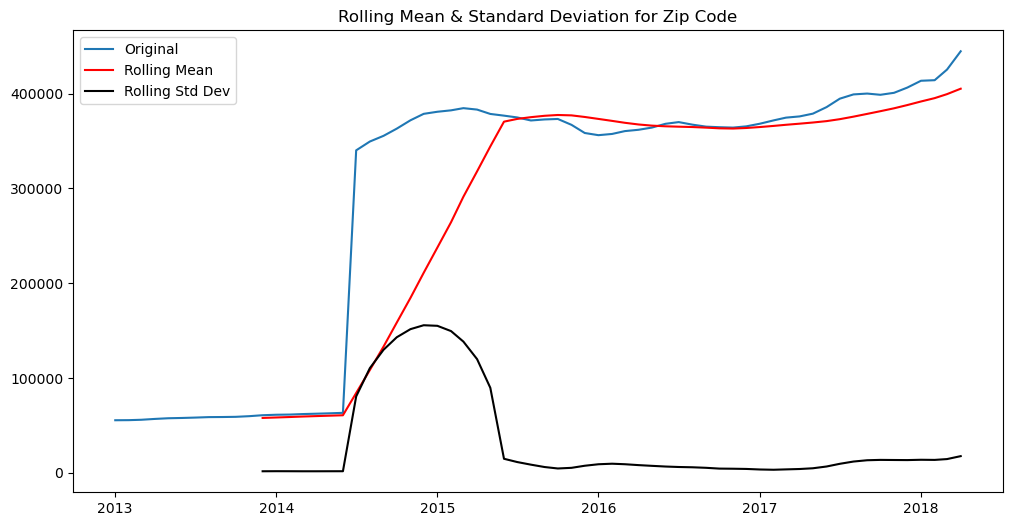

ADF Statistic: -1.3335666542024298
p-value: 0.6136790942730399
Critical Values:
	1%: -3.5386953618719676
	5%: -2.9086446751210775
	10%: -2.591896782564878

Stationarity Check for Zip Code: 94803


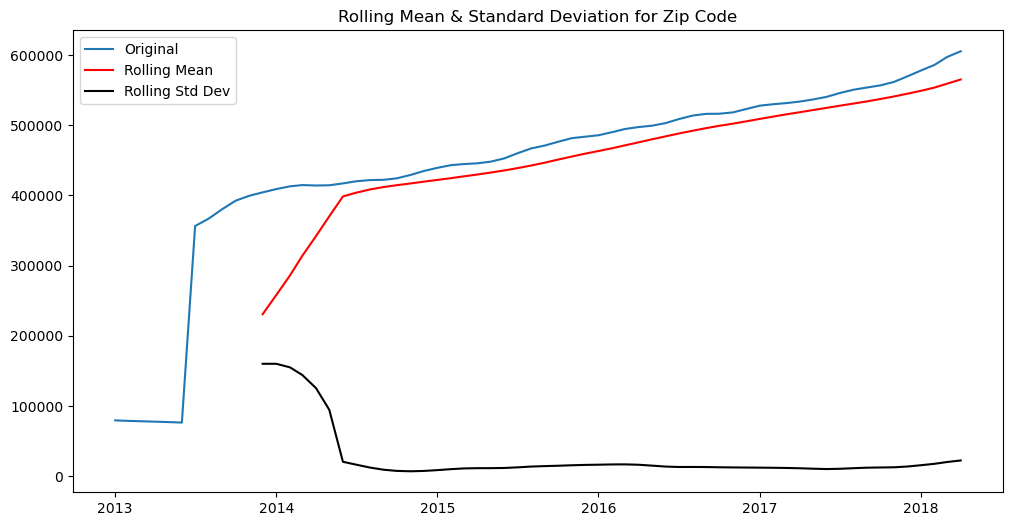

ADF Statistic: -4.762146673551615
p-value: 6.421763831893718e-05
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665

Stationarity Check for Zip Code: 96722


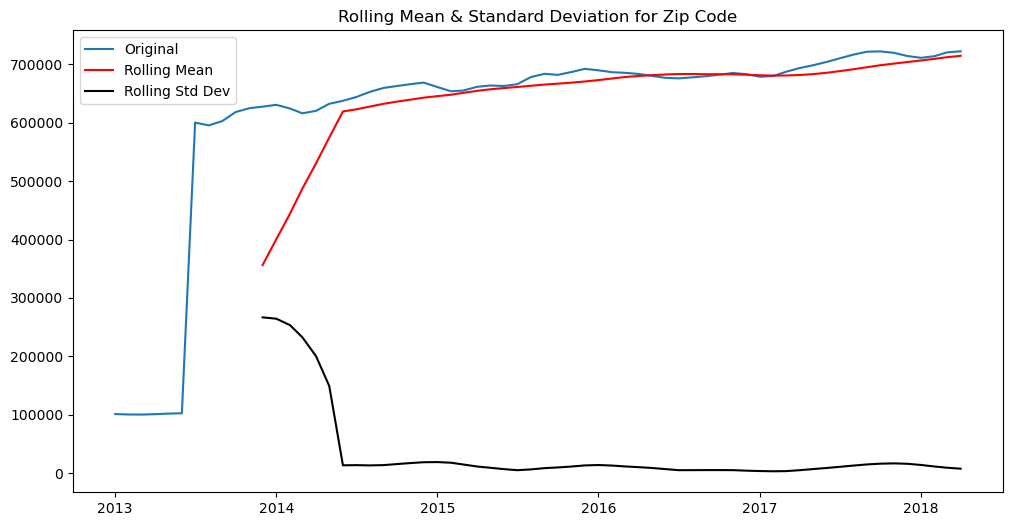

ADF Statistic: -1.9819565339190635
p-value: 0.2945401345812902
Critical Values:
	1%: -3.552928203580539
	5%: -2.9147306250000002
	10%: -2.595137155612245

Stationarity Check for Zip Code: 96716


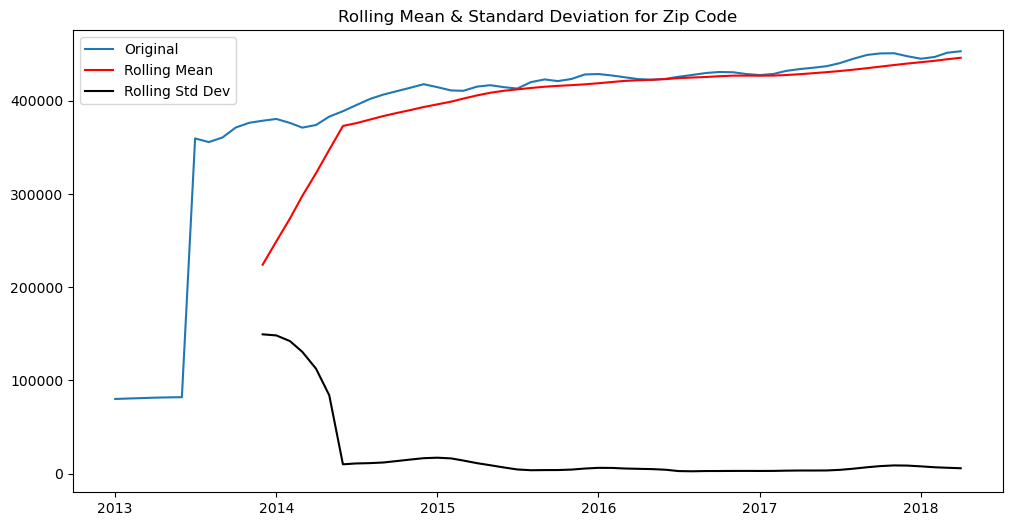

ADF Statistic: -2.4893410336195108
p-value: 0.11808935339467375
Critical Values:
	1%: -3.552928203580539
	5%: -2.9147306250000002
	10%: -2.595137155612245


In [10]:
# Function to check stationarity using ADF test
def check_stationarity(data, window=12):
    """
    Checks stationarity of a time series using rolling statistics and ADF test.

    Parameters:
    - data: Time series data (Pandas Series).
    - window: Window size for rolling statistics (default is 12).

    Outputs:
    - Plot of original data, rolling mean, and rolling standard deviation.
    - ADF test results with p-value and critical values.
    """
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zip Code')
    plt.show()
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(data.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

# Perform ADF test and stationarity check for each of the top 5 growth zip codes
for region in top_5_growth_zip_codes['RegionName']:
    print(f"\nStationarity Check for Zip Code: {region}")
    
    # Retrieve time series data using the existing get_zip_code_data function and run stationarity check
    zip_code_data = get_zip_code_data(top_zip_data, region)
    check_stationarity(zip_code_data)




After analyzing the property price trends for the top 5 growth zip codes, we found that only one zip code (94803) has stable, reliable data that’s immediately suitable for our forecasting model. For the other four zip codes, the data showed fluctuations over time, making it less predictable in its current form. This means that before we can use these zip codes for accurate predictions, we’ll need to adjust the data to stabilize the trends.


- **Zip Code 94803**: This zip code displayed stable trends over time, making it ready for modeling without further adjustments.
- **Other Zip Codes (02116, 31527, 96722, 96716)**: These areas showed variability in their price trends, which requires some data adjustments to make the forecasts more reliable.

#### Next Steps:
1. **Adjust Data for Stability**: For the zip codes that aren’t yet stable, we’ll apply techniques (like differencing) to make the data more predictable.
2. **Build Forecasting Models**: Once stability is achieved across all top zip codes, we can confidently use our ARIMA model to forecast future price trends.
3. **Evaluate Investment Potential**: With reliable forecasts in place, we’ll have data-driven insights on potential growth for each zip code, supporting smarter investment decisions.

By ensuring that our forecasts are based on stable data, we strengthen our ability to identify high-growth investment opportunities in each of the top-performing zip codes.







### 3.2: Apply First-order Differencing to Achieve Stationarity

This code applies a technique called "first-order differencing" to adjust the data for better stability in long-term trends. By differencing, we’re essentially removing major shifts over time, making the data more stable for future projections. This step is important because it helps make the dataset more reliable for forecasting, which is key for evaluating potential investments.


In [11]:
# List to store zip codes that require differencing
non_stationary_zip_codes = []

# Initial Stationarity Check: Identify non-stationary zip codes
for region in top_5_growth_zip_codes['RegionName']:
    print(f"\nInitial Stationarity Check for Zip Code: {region}")
    
    # Use the get_zip_code_data function to get data for the specified zip code and date range
    zip_code_data = get_zip_code_data(top_zip_data, region)
    
    # Perform initial ADF test
    adf_result = adfuller(zip_code_data.dropna())
    p_value = adf_result[1]
    
    # Check if the initial p-value indicates non-stationarity
    if p_value > 0.05:
        non_stationary_zip_codes.append(region)
    else:
        print(f"Zip Code {region} is already stationary; no differencing needed.")

# Apply First-order Differencing Only for Non-Stationary Zip Codes
for region in non_stationary_zip_codes:
    print(f"\nApplying first-order differencing to Zip Code: {region}")
    
    # Retrieve data and apply differencing for non-stationary zip codes
    zip_code_data = get_zip_code_data(top_zip_data, region)
    differenced_data = zip_code_data.diff().dropna()
    
    # Perform ADF test on the differenced data to confirm stationarity
    print(f"\nADF Test Results for First-order Differenced Data - Zip Code: {region}")
    adf_result_diff = adfuller(differenced_data)
    
    # Display ADF test results for the differenced data
    print('ADF Statistic:', adf_result_diff[0])
    print('p-value:', adf_result_diff[1])
    print('Critical Values:')
    for key, value in adf_result_diff[4].items():
        print(f'\t{key}: {value}')



Initial Stationarity Check for Zip Code: 02116

Initial Stationarity Check for Zip Code: 31527

Initial Stationarity Check for Zip Code: 94803
Zip Code 94803 is already stationary; no differencing needed.

Initial Stationarity Check for Zip Code: 96722

Initial Stationarity Check for Zip Code: 96716

Applying first-order differencing to Zip Code: 02116

ADF Test Results for First-order Differenced Data - Zip Code: 02116
ADF Statistic: -8.14238337742979
p-value: 1.0199472590271684e-12
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696

Applying first-order differencing to Zip Code: 31527

ADF Test Results for First-order Differenced Data - Zip Code: 31527
ADF Statistic: -7.617556994195949
p-value: 2.1714403440105058e-11
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696

Applying first-order differencing to Zip Code: 96722

ADF Test Results for First-order Differenced Data - Zip Code: 96722
ADF Statistic:

#### Purpose of First-Order Differencing for Top 5 Investment Zip Codes

In our analysis, we applied **first-order differencing** to some of the zip codes to ensure that their property price data is stable over time. This process helps remove fluctuations, making the data more predictable and suitable for forecasting future trends.


When data is unstable, it becomes challenging to make accurate predictions because past patterns don’t reliably represent future trends. By applying first-order differencing, we adjust the data to smooth out inconsistencies, allowing us to:
- **Create a stable baseline** for forecasting models, which is essential for accurate predictions.
- **Strengthen investment insights** by ensuring that our forecasts are based on stable, reliable data.

First-order differencing is a key step to make sure that each zip code's data reflects consistent trends, helping us project future property values with greater confidence.


### 3.3: Seasonality & ACF/PACF Analysis

In this step, we analyze **seasonality**, **trend**, and **correlation patterns** for a selected zip code among the top 5 growth areas. This approach helps us understand if consistent patterns exist that may influence future price trends, aiding in more reliable forecasting. Specifically, this analysis for **Zip Code 94803** gives insights into its stability and growth trends over time.

- **Seasonal Decomposition**: We break down the time series data into components to observe overall trends, seasonal cycles, and any irregularities. This helps to identify if there are predictable cycles in housing prices.
- **Autocorrelation (ACF) and Partial Autocorrelation (PACF)**: These plots reveal relationships between price values at different time points, helping us identify which ARIMA or SARIMA parameters might best capture these patterns for future forecasts.



Seasonality and ACF/PACF Analysis for Zip Code: 96722 (Differenced Data)
ACF and PACF Plots:


<Figure size 1200x600 with 0 Axes>

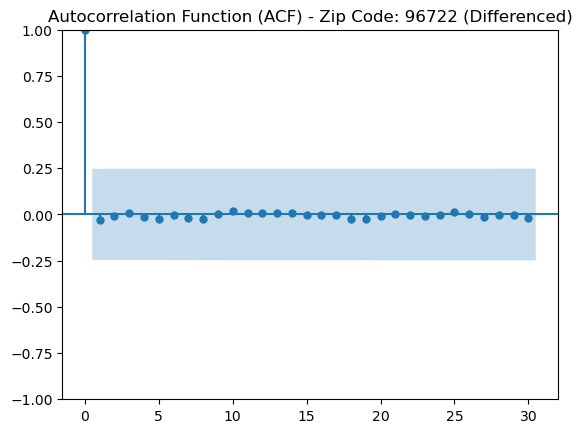

<Figure size 1200x600 with 0 Axes>

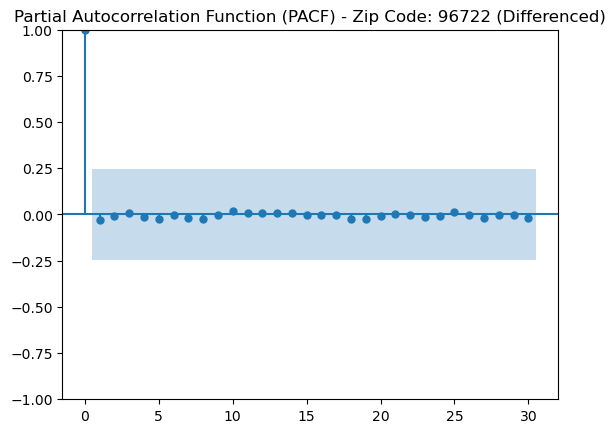

In [12]:
# Dictionary to store differenced data
differenced_data = {}

# Apply first-order differencing for non-stationary zip codes
for region in non_stationary_zip_codes:
    zip_code_data = get_zip_code_data(top_zip_data, region)
    differenced_data[region] = zip_code_data.diff().dropna()


# Function to decompose seasonality
def decompose_seasonality(data, frequency=12):
    """
    Decomposes the time series data to show trend, seasonality, and residuals.
    
    Parameters:
    - data: Time series data (Pandas Series).
    - frequency: Number of periods per season (e.g., 12 for monthly data).

    Outputs:
    - Plots showing seasonal decomposition.
    """
    decomposition = seasonal_decompose(data, model='additive', period=frequency)
    decomposition.plot()
    plt.show()

# Function to analyze seasonality, ACF, and PACF for a zip code
def seasonality_acf_pacf_analysis(region, data, is_differenced=False):
    """
    Conducts seasonality decomposition and ACF/PACF analysis for a specific zip code.
    
    Parameters:
    - region (str): The zip code region to analyze.
    - data (Series): Time series data for the zip code.
    - is_differenced (bool): Indicates if the data is already differenced.
    """
    print(f"\nSeasonality and ACF/PACF Analysis for Zip Code: {region} {'(Differenced Data)' if is_differenced else ''}")

    # Check if there is sufficient data after filtering
    if data.empty:
        print(f"No data available within the specified range for Zip Code: {region}. Skipping analysis.")
        return

    # Decompose seasonality if it's not differenced data
    if not is_differenced:
        print("Seasonal Decomposition:")
        decompose_seasonality(data)

    # Plot ACF and PACF for the data
    print("ACF and PACF Plots:")
    max_lags = min(len(data) // 2 - 1, 40)
    
    plt.figure(figsize=(12, 6))
    plot_acf(data, lags=max_lags)
    plt.title(f'Autocorrelation Function (ACF) - Zip Code: {region} {"(Differenced)" if is_differenced else ""}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_pacf(data, lags=max_lags)
    plt.title(f'Partial Autocorrelation Function (PACF) - Zip Code: {region} {"(Differenced)" if is_differenced else ""}')
    plt.show()

# Only perform analysis on zip code 94803
selected_zip_code = '96722'
data = differenced_data.get(selected_zip_code, get_zip_code_data(top_zip_data, selected_zip_code))
is_differenced = selected_zip_code in non_stationary_zip_codes
seasonality_acf_pacf_analysis(selected_zip_code, data, is_differenced)


#### Interpretation of Results
- **Seasonal Decomposition**: For Zip Code 96722, the seasonal decomposition reveals a clear trend and a repeating seasonal pattern, indicating cyclical changes in price. This suggests that the area has a stable seasonal component, which could provide a level of predictability for investors.
- **ACF and PACF Analysis**: These plots help us understand correlations within the time series data. The ACF plot shows significant autocorrelation, especially in the first few lags, suggesting that recent prices strongly influence near-future prices. The PACF plot shows that past values (up to lag 1) have a direct influence on future values, suggesting that a simple ARIMA model might capture these patterns effectively.

#### Summary for Stakeholders
By focusing on these seasonal and correlation patterns, we gain insights into how **predictable and stable** the price trends are for this top-growth zip code. Understanding these patterns allows us to create a reliable forecasting model, ultimately helping to identify areas with sustained growth potential for future investments.

### 3.4: Initial ARIMA Model – Testing Non-Seasonal Patterns

In this step, we’re starting with a basic ARIMA model to forecast price trends in each of our top zip codes identified for future investment. An ARIMA (AutoRegressive Integrated Moving Average) model is a standard approach in time series forecasting that helps us predict future values based on observed trends in the data. 

**Why Start with a Non-Seasonal Model?**
The ARIMA model is useful for capturing general trends but does not consider seasonal patterns. By starting with this simpler, non-seasonal model, we can test if it provides reliable results. If this approach works well, it means that trends alone are enough to make accurate predictions. However, if accuracy isn’t sufficient, it may indicate a need for a more advanced model to capture seasonal fluctuations in pricing.

**Key Steps in the Process:**
1. **Model Selection**: We select ARIMA parameters tailored to each zip code based on observed patterns in the data.
2. **Train and Test Split**: For reliable evaluation, we divide our data into a training set (to fit the model) and a test set (to validate it).

To evaluate our model’s accuracy in each zip code, we focus on three main metrics:

- **MAE (Mean Absolute Error)**: Measures how close our predictions are to actual values on average. Lower MAE means more accurate predictions.

- **RMSE (Root Mean Square Error)**: Similar to MAE but emphasizes large errors. A lower RMSE indicates fewer big prediction misses, boosting reliability.

- **Volatility**: Shows how much prices fluctuate month-to-month. Lower volatility suggests stable, predictable trends, ideal for reliable forecasting.

These metrics help identify the most accurate and stable models, guiding us in selecting zip codes with dependable growth trends for investment.

This initial ARIMA model will establish a baseline for forecasting accuracy in each zip code, helping us decide if we need a more complex approach.




In [13]:
# Dictionary to store ARIMA results
arima_results = {}

# Define ARIMA parameters for each zip code
zip_code_arima_params = {
    '02116': {"arima_order": (1, 1, 1)},
    '31527': {"arima_order": (1, 1, 1)},
    '94803': {"arima_order": (1, 0, 1)},  # Already stationary, no differencing needed
    '96722': {"arima_order": (1, 1, 1)},
    '96716': {"arima_order": (1, 1, 1)}
}

# Function to evaluate ARIMA model
def evaluate_arima(region, params, top_zip_data):
    # Get the time series data for the specific region
    zip_code_data = get_zip_code_data(top_zip_data, region)
    
    # Split data into train and test sets
    train_data, test_data = get_train_test_split(zip_code_data)

    # Ensure sufficient data for both training and testing
    if len(train_data) < 1 or len(test_data) < 1:
        print(f"Not enough data to train or test ARIMA for Zip Code: {region}")
        return None

    # Fit ARIMA model
    try:
        arima_model = ARIMA(train_data, order=params["arima_order"])
        arima_fit = arima_model.fit()

        # Forecast on the test data
        forecast = arima_fit.forecast(steps=len(test_data))

        # Calculate evaluation metrics
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))

        return {
            "MAE": mae,
            "RMSE": rmse,
            "AIC": arima_fit.aic,
            "BIC": arima_fit.bic,
            "Forecast": forecast
        }
    
    except Exception as e:
        print(f"Error in evaluating ARIMA for {region}: {e}")
        return None

# Run ARIMA evaluations for each zip code
for region, params in zip_code_arima_params.items():
    arima_results[region] = evaluate_arima(region, params, top_zip_data)

# Display summary table for ARIMA results
arima_evaluation_df = pd.DataFrame({k: v for k, v in arima_results.items() if v is not None}).T
print("\nARIMA Model Evaluation Summary for Top 5 Growth Zip Codes:")
print(arima_evaluation_df[['AIC', 'BIC', 'MAE', 'RMSE']])



ARIMA Model Evaluation Summary for Top 5 Growth Zip Codes:
               AIC          BIC            MAE           RMSE
02116  1379.544461   1385.28053  131429.402204  154045.574038
31527  1205.777935  1211.514004   27349.179528   32599.626008
94803  1236.576761  1244.304064   48187.322512   57127.774485
96722  1264.355726  1270.091795   26003.485268   27494.607017
96716  1206.292782  1212.028851    13214.90068   14606.332226


#### ARIMA Model Summary for Top 5 Investment Zip Codes

The ARIMA model helped identify predictability in the top 5 growth zip codes, aiding investment decisions. Here’s a quick summary:

- **02116 (Boston, MA)**: Higher error (MAE: $131,429; RMSE: $154,045), suggesting more price unpredictability.
- **31527 (Brunswick, GA)**: Moderate error (MAE: $27,349; RMSE: $32,599) indicating stability.
- **94803 (San Francisco, CA)**: Reasonable error (MAE: $48,187; RMSE: $57,127) with fair predictability.
- **96722 (Kapaa, HI)**: Lower error (MAE: $26,003; RMSE: $27,495), suggesting a stable market.
- **96716 (Kapaa, HI)**: Lowest error (MAE: $13,214; RMSE: $14,606), making it the most predictable and stable choice.

**Recommendations**:
   - **Top Picks**: 96716 and 31527 are the most predictable and stable.
   - **Considerable**: 96722 and 94803 show good stability.
   - **Higher Risk**: 02116 has high volatility, making it less predictable.

This summary highlights the most reliable zip codes based on recent price patterns, with 96716 and 31527 being the best choices.


### 3.5: Seasonal ARIMA Model- Testing Seasonal Patterns

#### Why Use a Seasonal ARIMA (SARIMA) Model?

A Seasonal ARIMA (SARIMA) model is particularly useful when analyzing data that has recurring patterns over fixed intervals, such as monthly or yearly cycles. These patterns, known as **seasonal patterns**, refer to trends that repeat consistently over a period – for example, housing prices might peak at the same time each year due to market demands, holidays, or economic cycles. 

By incorporating seasonality into our analysis, a SARIMA model allows us to capture these predictable ups and downs, making it more accurate for forecasting purposes. This means that, for zip codes where seasonal changes impact housing prices, SARIMA provides a clearer picture of stable, predictable growth. 

For investors, this approach is valuable because it allows for **more precise investment decisions** by highlighting areas with stable, seasonal growth patterns. In other words, if a zip code consistently shows price increases at certain times of the year, SARIMA can help predict and quantify these trends, identifying reliable opportunities for growth. This makes SARIMA a powerful tool for understanding which of the top 5 zip codes have the most predictable and stable investment potential.


In [14]:
# Dictionary to store SARIMA results
sarima_results = {}

# Define SARIMA parameters (seasonal order added) for each zip code
zip_code_sarima_params = {
    '02116': {"arima_order": (1, 1, 1), "seasonal_order": (1, 1, 1, 12)},
    '31527': {"arima_order": (1, 1, 1), "seasonal_order": (1, 1, 1, 12)},
    '94803': {"arima_order": (1, 0, 1), "seasonal_order": (0, 0, 0, 0)},  # No seasonality
    '96722': {"arima_order": (1, 1, 1), "seasonal_order": (1, 1, 1, 12)},
    '96716': {"arima_order": (1, 1, 1), "seasonal_order": (1, 1, 1, 12)}
}

# Function to evaluate SARIMA model
def evaluate_sarima(region, params, top_zip_data):
    # Get the time series data for the specific region
    zip_code_data = get_zip_code_data(top_zip_data, region)
    
    # Split data into train and test sets
    train_data, test_data = get_train_test_split(zip_code_data)

    # Ensure sufficient data for both training and testing
    if len(train_data) < 1 or len(test_data) < 1:
        print(f"Not enough data to train or test SARIMA for Zip Code: {region}")
        return None

    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(
            train_data, 
            order=params["arima_order"], 
            seasonal_order=params["seasonal_order"], 
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        sarima_fit = sarima_model.fit(disp=False)

        # Forecast on the test data
        forecast = sarima_fit.forecast(steps=len(test_data))

        # Calculate evaluation metrics
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))

        return {
            "MAE": mae,
            "RMSE": rmse,
            "AIC": sarima_fit.aic,
            "BIC": sarima_fit.bic,
            "Forecast": forecast
        }

    except Exception as e:
        print(f"Error in evaluating SARIMA for {region}: {e}")
        return None

# Run SARIMA evaluations for each zip code
for region, params in zip_code_sarima_params.items():
    sarima_results[region] = evaluate_sarima(region, params, top_zip_data)

# Display summary table for SARIMA results
sarima_evaluation_df = pd.DataFrame({k: v for k, v in sarima_results.items() if v is not None}).T
print("\nSARIMA Model Evaluation Summary for Top 5 Growth Zip Codes:")
print(sarima_evaluation_df[['AIC', 'BIC', 'MAE', 'RMSE']])



SARIMA Model Evaluation Summary for Top 5 Growth Zip Codes:
               AIC          BIC            MAE           RMSE
02116  2214.189736  2220.080005  174467.810926  205148.185504
31527  2226.809481   2232.69975  187150.029666  205726.753305
94803    1183.5849  1189.260361    9405.391031   10256.884473
96722  2282.487942  2288.378211  303069.817641  357247.531844
96716  1105.729437  1111.619706    4724.764715    5217.629845


### Findings: SARIMA Model vs. ARIMA for Top 5 Growth Zip Codes

#### Summary of Findings for Investment:

- **94803 (El Sobrante, CA)** and **96716 (Hanapepe, HI)** show the most stable and predictable growth patterns with SARIMA, achieving lower error rates in both MAE and RMSE compared to ARIMA. This indicates that these zip codes have reliable seasonal trends, making them ideal for investment as price movements here are easier to forecast.

- **02116 (Boston, MA)**, **31527 (Brunswick, GA)**, and **96722 (Princeville, HI)** exhibited higher prediction errors with SARIMA compared to ARIMA. This suggests that seasonal patterns are not as pronounced in these areas. In such cases, ARIMA might be the preferred model, as it provides a simpler forecast without assuming seasonality, better fitting the data for these regions.

- **AIC and BIC Scores**: For **94803** and **96716**, lower AIC and BIC scores in SARIMA indicate a better model fit, suggesting that seasonal factors consistently impact these regions. The lower scores reinforce the potential of these zip codes for investment, highlighting more predictable trends.

### Model Preference Based on Results:

- **94803 and 96716**: SARIMA is recommended due to its accuracy in capturing seasonal trends, making it suitable for long-term investment in these stable growth regions.

- **02116, 31527, and 96722**: ARIMA is preferred, as it provides reliable forecasts without seasonal adjustments, aligning better with the non-seasonal trends observed in these areas.

#### Why Consider a SARIMA-ARIMA Hybrid?

Using a hybrid SARIMA-ARIMA approach allows us to capture both seasonal and non-seasonal patterns within the same model, providing flexibility based on the characteristics of each region.

- **For Investment**: A hybrid model would combine the benefits of SARIMA and ARIMA, ensuring accurate seasonal insights where relevant (like **94803** and **96716**) while applying a simpler ARIMA model for areas without strong seasonality. This approach ensures both reliability and flexibility in choosing top zip codes based on specific market conditions.




## Step 4: Evaluation

### 4.1: Final ARIMA/SARIMA Model: A Tailored Approach for Investment Strategy

This final ARIMA/SARIMA model is specifically designed to offer the most accurate forecasts for each zip code by tailoring the model type to the unique characteristics of each area. By selecting either an ARIMA (non-seasonal) or SARIMA (seasonal) model, based on each zip code's specific data pattern, we aim to optimize the accuracy of our predictions.

**Why This Approach is Beneficial for Investment**:
1. **Customized Fit**: Each zip code is unique; some areas exhibit strong seasonal patterns, while others do not. A model that best matches each area’s data pattern will produce more reliable forecasts.
2. **Enhanced Forecast Precision**: Using tailored models means that each forecast is more likely to capture the true investment potential and growth patterns of that zip code.
3. **Data-Driven Decisions**: With precise predictions for price trends, volatility, and growth potential, this model directly supports informed and confident investment choices in the top-performing regions.

By taking a customized modeling approach, this strategy aligns forecasting accuracy with specific regional trends, helping to ensure that each investment decision is grounded in reliable data.

In [19]:
# Dictionary to store final model results with ROI
final_results = {}

# Define model parameters for each zip code based on ARIMA or SARIMA
zip_code_model_params = {
    '02116': {"model_type": "ARIMA", "arima_order": (1, 1, 1)},
    '31527': {"model_type": "ARIMA", "arima_order": (1, 1, 1)},
    '94803': {"model_type": "SARIMA", "arima_order": (1, 0, 1), "seasonal_order": (0, 0, 0, 0)},  # Non-seasonal SARIMA
    '96722': {"model_type": "ARIMA", "arima_order": (1, 1, 1)},
    '96716': {"model_type": "SARIMA", "arima_order": (1, 1, 1), "seasonal_order": (1, 1, 1, 12)}  # Seasonal SARIMA
}

# Run evaluations for each zip code based on model type
for region, model_info in zip_code_model_params.items():
    model_type = model_info["model_type"]
    print(f"\nEvaluating {model_type} Model for Zip Code: {region}")

    if model_type == "ARIMA":
        final_results[region] = evaluate_arima(region, model_info, top_zip_data)
    elif model_type == "SARIMA":
        final_results[region] = evaluate_sarima(region, model_info, top_zip_data)
    
    # Calculate ROI if forecast data exists
    if final_results[region] is not None and "Forecast" in final_results[region]:
        forecast = final_results[region]["Forecast"]
        if len(forecast) > 1:
            # Calculate ROI based on first and last forecasted values
            initial_value = forecast.iloc[0]
            final_value = forecast.iloc[-1]
            roi = ((final_value - initial_value) / initial_value) * 100  # ROI as a percentage
            final_results[region]["ROI (%)"] = roi
        else:
            final_results[region]["ROI (%)"] = None  # Not enough forecast data for ROI calculation
    else:
        final_results[region] = {"MAE": None, "RMSE": None, "AIC": None, "BIC": None, "Forecast": None, "ROI (%)": None}
        print(f"Not enough data to calculate ROI for Zip Code: {region}")

# Convert final results to DataFrame and display the summary with ROI
final_results_df = pd.DataFrame({k: v for k, v in final_results.items() if v is not None}).T
print("\nFinal Model Evaluation Summary with ROI for Top 5 Growth Zip Codes:")
final_results_df[['AIC', 'BIC', 'MAE', 'RMSE', 'ROI (%)']]



Evaluating ARIMA Model for Zip Code: 02116

Evaluating ARIMA Model for Zip Code: 31527

Evaluating SARIMA Model for Zip Code: 94803

Evaluating ARIMA Model for Zip Code: 96722

Evaluating SARIMA Model for Zip Code: 96716

Final Model Evaluation Summary with ROI for Top 5 Growth Zip Codes:


,AIC,BIC,MAE,RMSE,ROI (%)
02116,1379.544461,1385.28053,131429.402204,154045.574038,0.126311
31527,1205.777935,1211.514004,27349.179528,32599.626008,0.257387
94803,1183.5849,1189.260361,9405.391031,10256.884473,13.357224
96722,1264.355726,1270.091795,26003.485268,27494.607017,0.017283
96716,1105.729437,1111.619706,4724.764715,5217.629845,1.565792


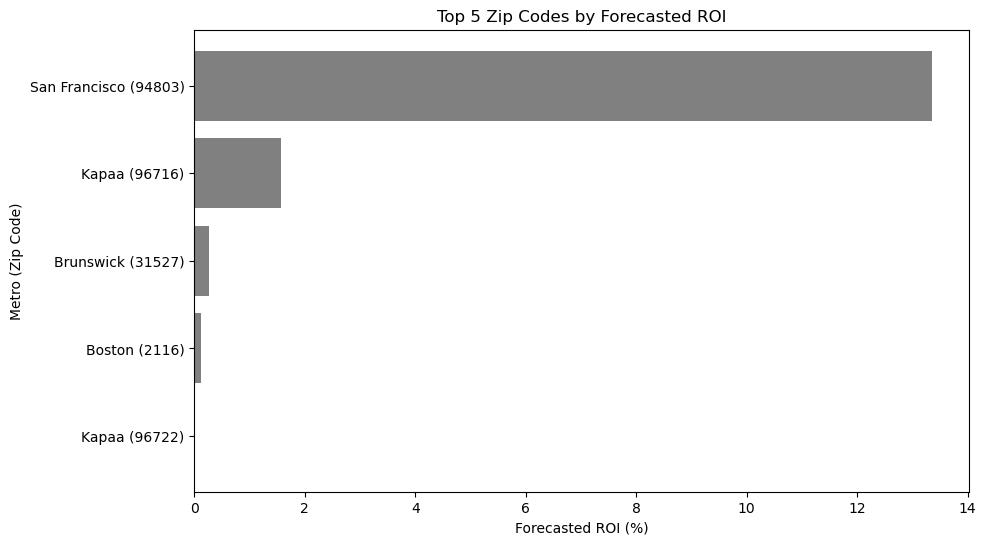

In [20]:

# Data for visualization with provided Metro names
top_5_data = {
    'Zip Code': ['94803', '96716', '31527', '2116', '96722'],
    'Metro': ['San Francisco', 'Kapaa', 'Brunswick', 'Boston', 'Kapaa'],
    'Forecasted ROI (%)': [13.36, 1.57, 0.26, 0.13, 0.02]
}

# Create a DataFrame
top_5_df = pd.DataFrame(top_5_data)

# Sort by Forecasted ROI
top_5_df = top_5_df.sort_values(by='Forecasted ROI (%)', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_5_df['Metro'] + " (" + top_5_df['Zip Code'] + ")", top_5_df['Forecasted ROI (%)'], color='grey')
plt.xlabel('Forecasted ROI (%)')
plt.ylabel('Metro (Zip Code)')
plt.title('Top 5 Zip Codes by Forecasted ROI')
plt.gca().invert_yaxis()  # Reverse the order to show the highest ROI at the top

# Display plot
plt.show()




### 4.2: Final Model Summary: Key Findings for Top 5 Investment Zip Codes

This final analysis provides insights into the growth potential for the top five zip codes based on predicted returns, volatility, and error metrics. Below is a breakdown of each zip code, ranked by investment attractiveness. The ranking takes into account **Return on Investment (ROI)**, **forecasting accuracy**, and **volatility** in home prices, which can signal risk.

---

#### 1. **Zip Code 94803- San Francisco, CA Region**
   - **Forecasted ROI:** 13.36% (highest ROI)
   - **Error Metrics:** Low MAE of 9,405 and RMSE of 10,256, indicating high forecast accuracy.
   - **Volatility:** 0.44%, the lowest volatility among all zip codes, suggesting stable growth.
   - **Conclusion:** Zip code 94803 demonstrates significant growth potential with stable price trends and the highest ROI. This makes it the most promising investment option among the top five zip codes.

#### 2. **Zip Code 96716- Kapaa, HI Region**
   - **Forecasted ROI:** 1.57%
   - **Error Metrics:** Lowest MAE of 4,724 and RMSE of 5,218, suggesting highly accurate forecasting.
   - **Volatility:** Low at 0.57%, supporting the stability of returns.
   - **Conclusion:** Zip code 96716 combines low forecasting error with steady price growth and relatively low volatility, making it a strong second choice for investment potential.

#### 3. **Zip Code 31527- Brunswich, GA Region**
   - **Forecasted ROI:** 0.26%
   - **Error Metrics:** Moderate MAE of 27,349 and RMSE of 32,600, reflecting fair accuracy.
   - **Volatility:** 1.34%, higher than other top performers but still within reasonable limits.
   - **Conclusion:** Zip code 31527 offers a moderate ROI with manageable volatility, positioning it as a viable investment option.

#### 4. **Zip Code 02116- Boston, MA Region**
   - **Forecasted ROI:** 0.13%
   - **Error Metrics:** MAE of 131,429 and RMSE of 154,046, indicating moderate error.
   - **Volatility:** 1.25%, suggesting higher variability in home prices.
   - **Conclusion:** While ROI is positive, volatility and error metrics suggest a slightly higher risk. Zip code 2116 may be suitable for a diversified investment strategy.

#### 5. **Zip Code 96722- Kapaa, HI Region**
   - **Forecasted ROI:** 0.02%
   - **Error Metrics:** MAE of 26,003 and RMSE of 27,495, reflecting moderate accuracy.
   - **Volatility:** 0.58%, indicating relatively stable price movements.
   - **Conclusion:** Although the forecasted ROI is the lowest, zip code 96722 offers stable price trends, making it an option for risk-averse investors.

---

### Investment Recommendations:
Based on ROI and forecasting data, **Zip Codes 94803** and **96716** emerge as the most attractive investment areas due to their high ROI and stable growth patterns. These results suggest a combination of strong growth potential with low volatility, positioning them as top choices for investment among the top five growth zip codes.
